Getting started
===============
In this part we are going to show you how to run a program on a GPU, this is
done using an example program, which is converted in a few steps to run on the
GPU. The example program we are going to look at calculates the Mandelbrot set.

0 Sequential implementation
---------------------------
The sequential version contains a function called `mandelbrot`, which is all the
logic we need to calculate the Mandelbrot set.
```python
def mandelbrot(z, max_iterations):
    c = z
    for i in xrange(max_iterations):
        if abs(z) > 2:
            return i
        z = z*z + c
    return max_iterations
```
It takes a complex number `z` and a maximum number of iterations to be run.

To setup the function we have a lot of variables with default values defining
width and height of the image we are generating, how many iterations should at
most be run in the `mandelbrot` function, and which area of the fractal should
be shown (default is everything).

It then creates two arrays, `reals` and `imaginaries`, with an even spread of
numbers from between the mins and maxes described above. These numbers are used
as the real and imaginary parts of the complex numbers we are doing our
calculations on.

The Mandelbrot set is then calculated for each combination of the two arrays.
```python
for i in xrange(width):
    for j in xrange(height):
        res[i, j] = mandelbrot(complex(reals[j], imaginaries[i]), max_iterations)
```

In [6]:
import numpy as np
import time

def mandelbrot(z, max_iterations):
    c = z
    for i in range(max_iterations):
        if abs(z) > 2:
            return i
        z = z*z + c
    return max_iterations

width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0

start_time = time.time()
# Creates a list of equally distributed numbers
reals = np.linspace(xmin, xmax, width)
imaginaries = np.linspace(ymax, ymin, height)

# Empty array for result
res = np.empty((width, height))

for i in range(width):
    for j in range(height):
        res[i, j] = mandelbrot(complex(reals[j], imaginaries[i]), max_iterations)
        
total_time_seq = time.time() - start_time

1 Before we start
-----------------
Before we start converting the program into OpenCL, we need to lay some
groundwork. We need to understand how to make the program run on the GPU and how
to get our data to and from it.

The first thing we need to do is import the library.
```python
import pyopencl as cl
```

Then we need to create a context and command queue, such that we can run our
code.
```python
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
```
All code submitted to the same queue are run in order.

To get code onto the GPU we will need to use the `Program` function from the
imported `pyopencl` library. The first argument is the context we created and
the second argument is the code we want to run. The code is written in a C++-like
language, but with some changes.  Code is run inside kernels, which you mark
with `__kernel` before the functions return type, which always will be `void`,
because it should not return anything as results are copied from the GPU's
memory.
```python
prg = cl.Program(ctx, """
        // Your code here
        __kernel void SomeKernel(
            __global const float *readOnlyArgument,
            __global float *writeableArgument,
            int someConstant)
        {
            int i = get_global_id(0);
        }
        """).build()
```
Here `get_global_id` gets our current index for a given dimension, starting from
0 where the highest number is the inner most dimension.
```python
# python loops
for i in range(n):
    for j in range(m):
        # Do something

prg = cl.Program(ctx, """
        // Your code here
        __kernel void SomeKernel()
        {
            int i = get_global_id(0);
            int j = get_global_id(1);
            // do something
        }
        """).build()
```

To calculate using our own data on the GPU, we need to copy them there. Before
we do that, we need to get hold of the flags. These are needed to tell the GPU
what it is allowed to do with the data.
```python
mf = cl.mem_flags
```
The available memory flags are:
- ALLOC\_HOST\_PTR - Allocate an array on the GPU the same size as an array on the host
- COPY\_HOST\_PTR - Copy data from the host array to the GPU
- USE\_HOST\_PTR - Indicates that the GPU should use the host memory pointer
- READ\_ONLY - The GPU can only read data, behaviour of writing data is undefined
- WRITE\_ONLY - The GPU can only write data, behaviour of reading data is undefined
- READ\_WRITE - The GPU can read and write data
- HOST\_NO\_ACCESS - The host promises not to read or write
- HOST\_READ\_ONLY - The host promises to only read the data
- HOST\_WRITE\_ONLY - The host promises to only write the data

To copy the data we can use the `Buffer` function with the memory flags.
```python
read_only_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=reals)
res_dev = cl.Buffer(ctx, mf.WRITE_ONLY, size=res.nbytes)
```

Then running our kernel can be done using the result from our earlier use of
`cl.Program`. The second argument defines the dimensions of our kernel.
```python
prg.SomeKernel(
        queue,
        (height, width),
        None,
        read_only_device,
        write_only_device,
        np.int32(some_constant))
```

When we are done with our calculations we can copy from the device to the host
using the `cl.enqueue_copy` function.
```python
cl.enqueue_copy(queue, host_array, device_array).wait()
```

2 Naïve implementation
----------------------
In this version we have taken the naïve approach and done a direct translation
of the program. As there is no library for complex numbers in we have chosen to
use the built-in type `float2`, which is a vector type for 2D floating point
vectors. OpenCL has multiple types, which support vector types, those are bool,
char, uchar, short, ushort, int, uint, long, ulong, half, float, and double.
The length of the vector types can be 2, 3, 4, 8, and 16.

The only translation we have done in this version is the `mandelbrot`
function and the complex arithmetic, which means all data is still generated and
sent from the host.

```python
prg = cl.Program(ctx, """
        float2 complex_product(float2 a, float2 b) {
            float2 res;
            res.x = a.x*b.x - a.y*b.y;
            res.y = a.x*b.y + b.x*a.y;
            return res;
        }

        __kernel void mandelbrot(
            __global const float2 *zs,
            __global int *res,
            ushort width,
            ushort max_iterations)
        {
            int x = get_global_id(0);
            int y = get_global_id(1);

            float2 z = zs[x*width+y];
            float2 c = z;

            res[y*width+x] = 0;
            for (int i = 0; i < max_iterations; i++) {
                if (z.x*z.x + z.y*z.y <= 4.0f) {
                    res[x*width+y] = i+1;
                    z = complex_product(z,z);
                    z.x = z.x + c.x;
                    z.y = z.y + c.y;
                }
            }
        }
        """).build()
```

In [7]:
import numpy as np
import pyopencl as cl
import time

# Getting context for running on the GPU
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

prg = cl.Program(ctx, """
        float2 complex_product(float2 a, float2 b) {
            float2 res;
            res.x = a.x*b.x - a.y*b.y;
            res.y = a.x*b.y + b.x*a.y;
            return res;
        }

        __kernel void mandelbrot(
            __global const float2 *zs,
            __global int *res,
            ushort width,
            ushort max_iterations)
        {
            int x = get_global_id(0);
            int y = get_global_id(1);

            float2 z = zs[x*width+y];
            float2 c = z;

            res[x*width+y] = 0;
            for (int i = 0; i < max_iterations; i++) {
                if (z.x*z.x + z.y*z.y <= 4.0f) {
                    res[x*width+y] = i+1;
                    z = complex_product(z,z);
                    z.x = z.x + c.x;
                    z.y = z.y + c.y;
                }
            }
        }
        """).build()

width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0
reals = np.linspace(xmin, xmax, width)
imaginaries = np.linspace(ymax, ymin, height) * 1j

start_time = time.time()
# Creating a combination of all values in the two lists
zs = (reals+imaginaries[:, np.newaxis]).flatten().astype(np.complex64)

res = np.empty(width*height).astype(np.int32)

mf = cl.mem_flags
zs_dev = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=zs)
res_dev = cl.Buffer(ctx, mf.WRITE_ONLY, size=res.nbytes)

prg.mandelbrot(
        queue,
        (height, width),
        None,
        zs_dev,
        res_dev,
        np.uint16(width),
        np.uint16(max_iterations))

# Copying result from GPU to memory
cl.enqueue_copy(queue, res, res_dev).wait()

# Setting shape of array to help displaying it
res.shape = (width, height)

total_time_naive = time.time() - start_time

3 Less transfer implementation
------------------------------
Transferring data to and from the GPU takes time, which in turn makes our
calculations slower. So we should try to limit how much data we move around.
In the naïve version we generate our data on the host and create a 1000 by 1000
matrix, which is then transfered to the GPU. But we can be smarter than that.
By sending our lists of real and imaginary parts, we can then combine them on
the GPU saving both time and space, because we already have the coordinates of
from our two global ids.

```opencl
__kernel void mandelbrot(
    __global const float *re,
    __global const float *im,
    __global int *res,
    ushort width,
    ushort max_iterations)
{
    int x = get_global_id(1);
    int y = get_global_id(0);

    float2 z = (float2)(re[x], im[y]);
    float2 c = z;
```

In [8]:
import numpy as np
import pyopencl as cl
import time

# Getting context for running on the GPU
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

prg = cl.Program(ctx, """
        float2 complex_product(float2 a, float2 b) {
            float2 res;
            res.x = a.x*b.x - a.y*b.y;
            res.y = a.x*b.y + b.x*a.y;
            return res;
        }

        __kernel void mandelbrot(
            __global const float *re,
            __global const float *im,
            __global int *res,
            ushort width,
            ushort max_iterations)
        {
            int x = get_global_id(1);
            int y = get_global_id(0);

            float2 z = (float2)(re[x], im[y]);
            float2 c = z;

            res[y*width+x] = 0;
            for (int i = 0; i < max_iterations; i++) {
                if (z.x*z.x + z.y*z.y <= 4.0f) {
                    res[x*width+y] = i+1;
                    z = complex_product(z,z);
                    z.x = z.x + c.x;
                    z.y = z.y + c.y;
                }
            }
        }
        """).build()

width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0

start_time = time.time()
# Creates a list of equally distributed numbers
reals = np.linspace(xmin, xmax, width).astype(np.float32)
imaginaries = np.linspace(ymin, ymax, height).astype(np.float32)

res = np.empty(width*height).astype(np.int32)

# Falgs for memory on GPU
mf = cl.mem_flags

# Creating arrays on the GPU and transfering data
reals_dev = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=reals)
imaginaries_dev = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=imaginaries)
res_dev = cl.Buffer(ctx, mf.WRITE_ONLY, size=res.nbytes)

# Running the kernel
prg.mandelbrot(
        queue,
        (height, width),
        None,
        reals_dev,
        imaginaries_dev,
        res_dev,
        np.uint16(width),
        np.uint16(max_iterations))

# Copying result from GPU to memory
cl.enqueue_copy(queue, res, res_dev).wait()

# Setting shape of array to help displaying it
res.shape = (width, height)

total_time_less_transfer = time.time() - start_time

4 GPU only implementation
-------------------------
In this implementation we move the data generation to the GPU. This removes data
transfer to the GPU completely, which should reduce total computation time
considerably, especially when calculating with a higher resolution. Of course we
still need to transfer the result array from the GPU, which is the majority of
our data transfer, but reducing data transfer should be a priority.

```opencl
__kernel void mandelbrot(
    __global int *res,
    ushort width,
    float xmin,
    float xmax,
    float ymin,
    float ymax,
    ushort max_iterations)
{
    int x = get_global_id(1);
    int y = get_global_id(0);
    float widthf = width - 1.0f;

    float2 z;
    z.x = xmin + ((xmax-xmin)*x/widthf);
    z.y = ymax - ((ymax-ymin)*y/widthf);
    float2 c = z;
```

In [9]:
import numpy as np
import pyopencl as cl
import time

# Getting context for running on the GPU
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

prg = cl.Program(ctx, """
        float2 complex_product(float2 a, float2 b) {
            float2 res;
            res.x = a.x*b.x - a.y*b.y;
            res.y = a.x*b.y + b.x*a.y;
            return res;
        }

        __kernel void mandelbrot(
            __global int *res,
            ushort width,
            float xmin,
            float xmax,
            float ymin,
            float ymax,
            ushort max_iterations)
        {
            int x = get_global_id(1);
            int y = get_global_id(0);
            float widthf = width - 1.0f;

            float2 z;
            z.x = xmin + ((xmax-xmin)*x/widthf);
            z.y = ymax - ((ymax-ymin)*y/widthf);
            float2 c = z;

            res[y*width+x] = 0;
            for (int i = 0; i < max_iterations; i++) {
                if (z.x*z.x + z.y*z.y <= 4.0f) {
                    res[y*width+x] = i+1;
                    z = complex_product(z,z);
                    z.x = z.x + c.x;
                    z.y = z.y + c.y;
                }
            }
        }
        """).build()


width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0
res = np.empty(width*height).astype(np.int32)

start_time = time.time()
mf = cl.mem_flags
res_dev = cl.Buffer(ctx, mf.WRITE_ONLY, size=res.nbytes)

prg.mandelbrot(
        queue,
        (height, width),
        None,
        res_dev,
        np.uint16(width),
        np.float32(xmin),
        np.float32(xmax),
        np.float32(ymin),
        np.float32(ymax),
        np.uint16(max_iterations))

# Copying result from GPU to memory
cl.enqueue_copy(queue, res, res_dev).wait()

# Setting shape of array to help displaying it
res.shape = (width, height)

total_time_gpu_only = time.time() - start_time

5 GPU optimized implementation
------------------------------
This version includes a small, but significant, change to the code in regards to
performance. When using GPUs reading and writing from global memory is
expensive. Therefore by introducing a local variable for the result and only
writing it to global memory once, we can save a huge margin of time.

```opencl
int result = 0;
for (int i = 0; i < max_iterations; i++) {
    if (z.x*z.x + z.y*z.y <= 4.0f) {
        result = i+1;
        z = complex_product(z,z);
        z.x = z.x + c.x;
        z.y = z.y + c.y;
    }
}
res[y*width+x] = result;
```

In [15]:
import numpy as np
import pyopencl as cl
import time

# Getting context for running on the GPU
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

prg = cl.Program(ctx, """
        float2 complex_product(float2 a, float2 b) {
            float2 res;
            res.x = a.x*b.x - a.y*b.y;
            res.y = a.x*b.y + b.x*a.y;
            return res;
        }

        __kernel void mandelbrot(
            __global int *res,
            ushort width,
            float xmin,
            float xmax,
            float ymin,
            float ymax,
            ushort max_iterations)
        {
            int x = get_global_id(1);
            int y = get_global_id(0);
            float widthf = width - 1.0f;

            float2 z;
            z.x = xmin + ((xmax-xmin)*x/widthf);
            z.y = ymax - ((ymax-ymin)*y/widthf);
            float2 c = z;

            int result = 0;
            for (int i = 0; i < max_iterations; i++) {
                if (z.x*z.x + z.y*z.y <= 4.0f) {
                    result = i+1;
                    z = complex_product(z,z);
                    z.x = z.x + c.x;
                    z.y = z.y + c.y;
                }
            }
            res[y*width+x] = result;
        }
        """).build()


width = 1000
height = 1000
max_iterations = 100
xmin = -2.5
xmax = 1.5
ymin = -2.0
ymax = 2.0
res = np.empty(width*height).astype(np.int32)

start_time = time.time()
mf = cl.mem_flags
res_dev = cl.Buffer(ctx, mf.WRITE_ONLY, size=res.nbytes)

prg.mandelbrot(
        queue,
        (height, width),
        None,
        res_dev,
        np.uint16(width),
        np.float32(xmin),
        np.float32(xmax),
        np.float32(ymin),
        np.float32(ymax),
        np.uint16(max_iterations))

# Copying result from GPU to memory
cl.enqueue_copy(queue, res, res_dev).wait()

# Setting shape of array to help displaying it
res.shape = (width, height)
total_time_gpu_optim = time.time() - start_time

Visualizer
------------

The code below here can be run after any of the codes above and it will visualize the mandlebrot being calculated.

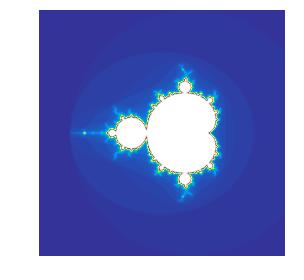

In [36]:
import matplotlib.pyplot as plt

# Displaying the Mandelbrot set
fig, ax = plt.subplots()

ax.imshow(res, interpolation='bicubic', cmap=plt.get_cmap("terrain"))
plt.axis("off")
plt.tight_layout()

plt.show()

0.023758888244628906 0.002965211868286133 0.023082256317138672


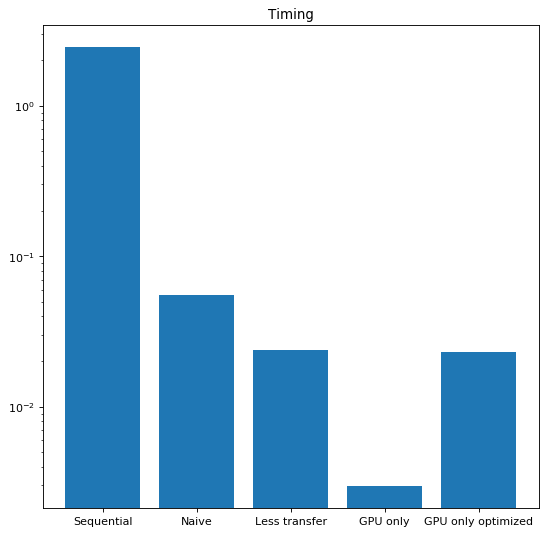

In [17]:
import matplotlib.pyplot as plt
names = ["Sequential", "Naive", "Less transfer", "GPU only", "GPU only optimized"]
values = [total_time_seq, total_time_naive, total_time_less_transfer, total_time_gpu_only, total_time_gpu_optim]

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Timing")
plt.bar(names, values)
plt.yscale("log")

plt.show()